In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Use SQLAlchemy automap_base() to reflect your tables into classes
Base = automap_base()

# reflect an existing database into a new model

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save a reference to those classes called Station and Measurement
Station = Base.classes.station
Measurement = Base.classes.measurement

# Save references to each table


In [9]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Link Python to the database by creating an SQLAlchemy session.
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Start by finding the most recent date in the data set.
# Using this date, retrieve the last 12 months of precipitation data by querying the 12 preceding months of data. 
# Note you do not pass in the date as a variable to your query.
# Select only the date and prcp values.
# Load the query results into a Pandas DataFrame and set the index to the date column.
# Sort the DataFrame values by date.
# Plot the results using the DataFrame plot method.

In [12]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement).order_by(Measurement.date.desc()).first()
print(most_recent_date.date)

2017-08-23


2016-08-23


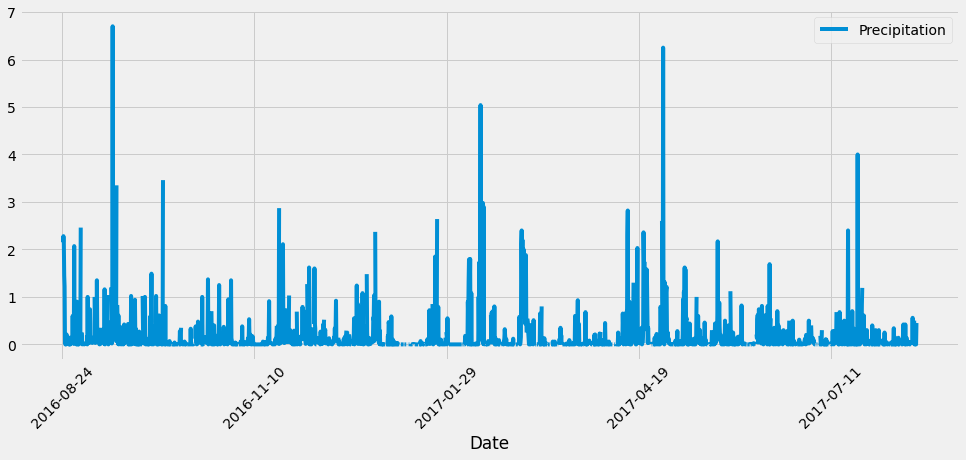

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 


# Calculate the date one year from the last date in data set.

one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(one_year_ago)

# date = dt.datetime(2016, 8, 23)

# Perform a query to retrieve the data and precipitation scores

# year_of_precip = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > date)    
# for row in year_of_precip:
#     print(row)

results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > one_year_ago).all()

# List comprehension solution
prcp_rows = [{"Date": result[0], "Precipitation": result[1]} for result in results]
prcp_rows

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(prcp_rows).set_index("Date")

# Sort the dataframe by date
df_ordered = df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
df_ordered.plot(figsize = (15,6), rot=45)



In [48]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Station Analysis
# Design a query to calculate the total number of stations in the dataset.
# Design a query to find the most active stations (i.e. which stations have the most rows?).
# List the stations and observation counts in descending order.
# Which station id has the highest number of observations?
# Using the most active station id, calculate the lowest, highest, and average temperature.
# Hint: You will need to use a function such as func.min, func.max, func.avg, and func.count in your queries.
# Design a query to retrieve the last 12 months of temperature observation data (TOBS).
# Filter by the station with the highest number of observations.
# Query the last 12 months of temperature observation data for this station.
# Plot the results as a histogram with bins=12.

In [16]:
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [17]:
# Design a query to calculate the total number stations in the dataset
station_list = session.query(Station.id,Station.station,Station.name)
station_list.count()

9

In [22]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active_station = session.query(Measurement.station,func.count(Measurement.station))\
                                    .group_by(Measurement.station)\
                                    .order_by(func.count(Measurement.station).desc()).limit(1).all()
most_active_station



[('USC00519281', 2772)]

In [35]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temperatures = session.query(Measurement.station, Station.name, 
                  func.min(Measurement.tobs), 
                  func.max(Measurement.tobs), 
                  func.avg(Measurement.tobs))\
                .filter(Measurement.station == Station.station)\
                .filter(Measurement.station == "USC00519281").all()

temperatures

[('USC00519281', 'WAIHEE 837.5, HI US', 54.0, 85.0, 71.66378066378067)]

In [37]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_twelve = session.query(Measurement.tobs)\
    .filter(Measurement.date > one_year_ago)\
    .filter(Measurement.station == "USC00519281")\
    .order_by(Measurement.tobs).all()


In [38]:
tobs_df = pd.DataFrame(tobs_twelve, columns=['temp'])
tobs_df.head()

,temp
0,59.0
1,59.0
2,59.0
3,60.0
4,60.0


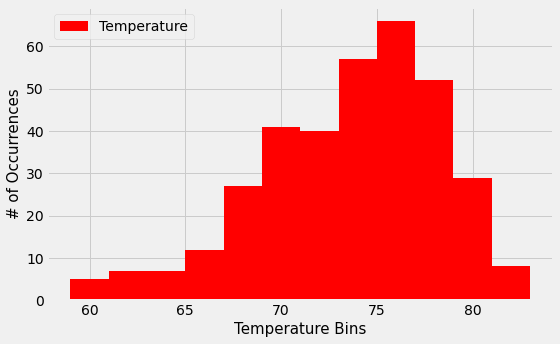

In [47]:
plt.subplots(figsize=(8,5))

plt.hist(tobs_df['temp'], bins=12, color="red")
plt.xlabel('Temperature Bins', fontsize=15)
plt.ylabel("# of Occurrences", fontsize=15)
labels = ['Temperature']
plt.legend(labels)
plt.tight_layout()
plt.savefig('temperature_hist.png')
plt.show()

# Close session

In [49]:
# Close Session
session.close()